__[A Baby Robot's Guide To Reinforcement Learning](https://towardsdatascience.com/tagged/baby-robot-guide)__

# The Upper Confidence Bound (UCB) Bandit Algorithm

## Multi-Armed Bandits: Part 4

![Photo by Artur Matosyan on Unsplash](https://cdn-images-1.medium.com/max/800/0*5EN3RNUburJPQrZY)

Photo by __[Artur Matosyan](https://unsplash.com/@artmatters?utm_source=medium&utm_medium=referral)__ on __[Unsplash](https://unsplash.com?utm_source=medium&utm_medium=referral)__

![](Images/green_babyrobot_small.gif)

# Overview

In this, the fourth part of our series on Multi-Armed Bandits, we're going to take a look at the Upper Confidence Bound (UCB) algorithm that can be used to solve the bandit problem. 


If you're not already familiar with the bandit problem and its terminology you may want to first take a look at the earlier parts of this series, which are as follows:


* [Part 1: Mathematical Framework and Terminology](https://towardsdatascience.com/multi-armed-bandits-part-1-b8d33ab80697)

* [Part 2: The Bandit Framework](https://towardsdatascience.com/multi-armed-bandits-part-2-5834cb7aba4b)

* [Part 3: Bandit Algorithms](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18)

    - [The Greedy Algorithm](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18#d7a7)
    - [The Optimistic-Greedy Algorithm](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18#1519)
    - [The Epsilon-Greedy Algorithm (ε-Greedy)](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18#0145)
    - [Regret](https://towardsdatascience.com/bandit-algorithms-34fd7890cb18#b390)

# Recap

<i>Baby Robot is lost in the mall. Using Reinforcement Learning we want to help him find his way back to his mum. However, before he can even begin looking for her, he needs to recharge, from a set of power sockets that each give a slightly different amount of charge.

Using the strategies from the multi-armed bandit problem we need to find the best socket, in the shortest amount of time, to allow Baby Robot to get charged up and on his way.</i>

![](Images/power_socket.png)

<i>Baby Robot has entered a charging room containing 5 different power sockets. Each of these sockets returns a slightly different amount of charge. We want to get Baby Robot charged up in the minimum amount of time, so we need to locate the best socket and then use it until charging is complete.
    
This is identical to the Multi-Armed Bandit problem except that, instead of looking for a slot machine that gives the best payout, we're looking for a power socket that gives the most charge.</i>

# Introduction

In the Power Socket problem, where we're trying to get the most charge in the shortest amount of time, we've seen that there's a trade-off between the amount of time we spend exploring, in search of the best socket, and the time spent exploiting the socket that currently gives the best return. If we take too long exploring then we're potentially missing out on using sockets that have already shown a high return. Alternatively, if we just exploit the sockets that have performed well then we might not find the best socket and potentially miss out on getting the maximum possible return.

Obviously the best approach would be to choose the best socket every time and this is what's known as the optimal policy. It's also obvious that this approach isn't actually practical, since you initially don't know which socket is the best. Some time has to be spent investigating how the sockets perform if you're going to find the best one and therefore it's not always possible to choose the best action.

The optimal policy, although only theoretical, can however be used to evaluate other policies, to see how close they come to being optimal. The difference between the return that would be achieved by the optimal policy and the amount of return actually achieved by the policy under test is known as the regret. In this case the return is the amount of charge from the sockets and the policy is the method or strategy used to select which sockets to use.

As we've seen, Epsilon-Greedy has linear regret. It continues to explore the set of all actions, long after it has gained sufficient knowledge to know which of these actions are bad actions to take.
A better approach, in terms of maximising the total reward, would be to restrict the sampling over time to the actions showing the best performance. This is the exact approach taken by the Upper Confidence Bound (UCB) strategy.

# The Upper Confidence Bound (UCB) Algorithm

Rather than performing exploration by simply selecting an arbitrary action, chosen with a probability that remains constant, the UCB algorithm changes its exploration-exploitation balance as it gathers more knowledge of the environment. It moves from being primarily focused on exploration, when actions that have been tried the least are preferred, to instead concentrate on exploitation, selecting the action with the highest estimated reward.

With UCB, 'Aₜ', the action chosen at time step 't', is given by:


![](Images/ucb_formula.png)


where;

* Qₜ(a) is the estimated value of action 'a' at time step 't'.
* Nₜ(a) is the number of times that action 'a' has been selected, prior to time 't'.
* 'c' is a confidence value that controls the level of exploration.



The formula for UCB can be thought of as being formed from 2 distinct parts:

### Exploitation:

* Qₜ(a) represents the exploitation part of the equation. UCB is based on the principle of "optimism in the fact of uncertainty", which basically means if you don't know which action is best then choose the one that currently looks to be the best. Taking this half of the equation by itself will do exactly that: the action that currently has the highest estimated reward will be the chosen action.



### Exploration:

* The second half of the equation adds exploration, with the degree of exploration being controlled by the hyper-parameter 'c'. Effectively this part of the equation provides a measure of the uncertainty for the action's reward estimate.

    If an action hasn't been tried very often, or not at all, then Nₜ(a) will be small. Consequently the uncertainty term will be large, making this action more likely to be selected. Every time an action is taken we become more confident about its estimate. In this case Nₜ(a) increments, and so the uncertainty term decreases, making it less likely that this action will be selected as a result of exploration (although it may still be selected as the action with the highest value, due to the exploitation term).

    When an action is not being selected, the uncertainty term will grow slowly, due to the log function in the numerator. Whereas, every time that the action is selected, the uncertainty will shrink rapidly due to the increase in Nₜ(a) being linear. So the exploration term will be larger for actions that have been selected infrequently, due to the uncertainty in the estimates of their rewards.

    As time progresses the exploration term gradually decreases (since as 'n' goes to infinity log n/n goes to zero), until eventually actions are selected based only on the exploitation term.

---

# UCB Implementation

To investigate the performance of the UCB algorithm we'll add another socket class to our test system. The full details of this test system are described in Part 2 of this series and all the code can be found in the github repository.

The UCB socket needs to slightly modify the base power socket class, to add uncertainty to the metric it uses to evaluate a socket. So the 'sample' function now returns the sum of the estimated mean reward and the uncertainty value, which is calculated as a function of the number of times the socket has been tried and the current time step.

The socket tester class reverts to the standard socket tester, with sockets being selected based only on the socket that returns the largest value from its sample function (i.e. the random sampling of the epsilon-greedy algorithm is no longer required).

In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

In [2]:
class UCBSocket( PowerSocket ):

    def __init__( self, q, **kwargs ):    
        """ initialize the UCB socket """                  
        
        # store the confidence level controlling exploration
        self.confidence_level = kwargs.pop('confidence_level', 2.0)       
                
        # pass the true reward value to the base PowerSocket   
        super().__init__(q)           
        
    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

In [3]:
class UCBSocketTester( SocketTester ):

    def __init__(self, socket_order=socket_order, confidence_level=2.0 ):                  
        """ initialize the socket tester """                  
        super().__init__(socket = UCBSocket, 
                         socket_order = socket_order, 
                         confidence_level = confidence_level, 
                         number_of_stats = 3) # a UCB socket tester records 3 bits of information over a run
        
    def get_socket_stats( self, t ):
        """ record the current values of each socket """
        socket_stats = [[socket.Q,socket.n,socket.uncertainty(t+1)] for socket in self.sockets]
        return socket_stats   

    def select_socket( self, t ):
        """ choose the socket with the current highest UCB reward """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])     
        return socket_index 

---

# Analysis of UCB

Using our test system we can analyse the performance of the UCB algorithm. To simplify the comparison, we've taken only the first 2 sockets from our standard set. These 2 sockets have mean reward values of 6 and 4 seconds of charge respectively. The relative contributions of each of the exploration and exploitation terms can clearly be seen in the graph below.

The main things to note here are:

* The total height of each bar represents the total UCB value. So, since at each time step we're choosing the socket that gives the maximum UCB value (this is what the argmax in the formula is doing), the socket with the tallest bar will be the socket that is chosen. 
    The number given at the top of each bar is the number of times this socket has been chosen. So you can see that this value will increase if this socket had the tallest bar at the previous time step.


* The shaded part of the bar represents the estimate of each socket's actual output (its Q value). As time progresses this estimate converges on the true mean output for each socket. So socket 1's Q value (the yellow shaded bar) heads towards its true output of 6 and the Q value for socket 2 goes towards its true mean value of 4.


* The solid part of each bar represents the exploration part of the equation. When a socket is used we become more certain about its true output and so the solid part of the bar will decrease in size. On the other hand, when a socket hasn't been tested, we become less certain of its output and so the exploration value will begin to increase in size.
    So, in the graph below, it can be seen how socket 2's exploration term, illustrated by the solid green part of the bar, gradually increases when socket 2 isn't being selected, until eventually it results in the total size of the bar being greater than that of socket 1 and, at this point, socket 2 is then chosen.

In [4]:
# do a single run with only 2 sockets to examine how the exploration and exploitation terms of the UCB equation vary
number_of_sockets = 2
number_of_steps = 20

# set the random seed to produce a recreatable graph
random.seed(0) 
np.random.seed(0)

tester = UCBSocketTester( socket_order[:number_of_sockets], confidence_level = 3.0 )
tester.run( number_of_steps )

(19, 114.77150488946722)

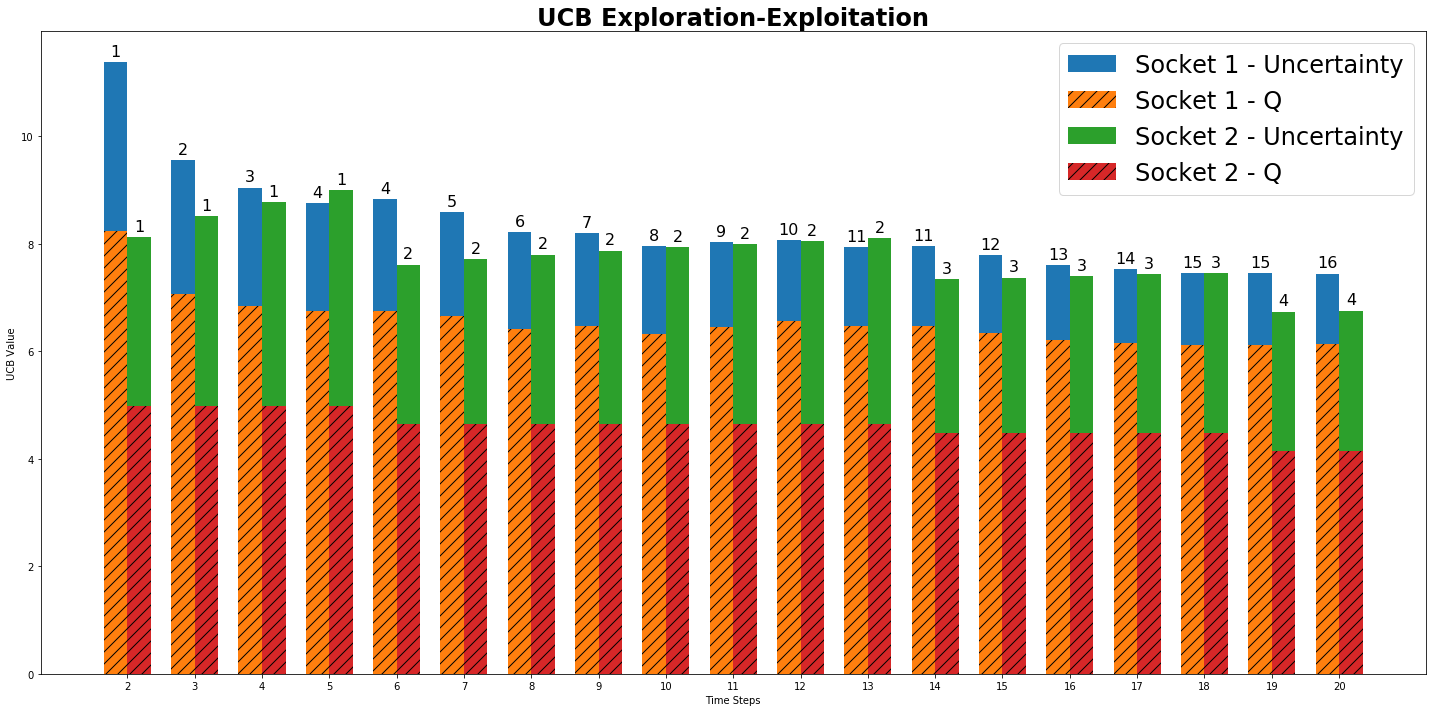

In [5]:
# get the parameters to graph from the socket stats
estimates = tester.socket_stats[:,:,0]
trials = tester.socket_stats[:,:,1]
uncertainty = tester.socket_stats[:,:,2]

# the label locations
# - start the examination after all sockets have been tried once
x = np.arange(len(estimates[:,0]))[2:]  
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = [ plt.bar(x, uncertainty[2:,0]+estimates[2:,0], align='edge', width= -width, label='Socket 1 - Uncertainty'),
           plt.bar(x, estimates[2:,0], align='edge', width= -width, label='Socket 1 - Q', hatch='//')]

rects2 = [ plt.bar(x, uncertainty[2:,1]+estimates[2:,1], align='edge',width= width, label='Socket 2 - Uncertainty'),
           plt.bar(x, estimates[2:,1], align='edge',width= width, label='Socket 2 - Q', hatch='//')]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('UCB Value')
ax.set_xlabel('Time Steps')
ax.set_title('UCB Exploration-Exploitation', fontsize=24, fontweight='bold')
ax.legend(fontsize=24)
ax.set_xticks(x)


def autolabel(rects,index,trials):
    """Attach a text label above each bar in *rects*, displaying its number of trials"""

    for i,rect in enumerate(rects[0]):
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(trials[i+2,index]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    size=16,
                    ha='center', va='bottom')  


autolabel(rects1,0,trials)
autolabel(rects2,1,trials)

fig.tight_layout()

# plt.savefig('ucb_exploration_exploitation.png')
plt.show()

### In-depth analysis of the UCB graph


So the points to note from the graph are as follows:
(note these points may differ slightly from the displayed graph, since within the notebook this will be generated on the fly - however the main points sill hold true)

* The socket uncertainty value is set to infinity if a socket has not yet been tried, causing an initial priming round to be performed, in which each action is tried once to get its initial value. This then avoids divide-by-zero errors in the exploration term when actions have not yet been tried and Nₜ(a) is equal to zero. Obviously this is only applicable when there are fewer possible actions 'k' than there are time steps 't', otherwise there wouldn't be enough time to try every action.


* Due to the priming round the graph begins at time step 2. The number of times that each socket has been selected is shown by the number at the top of each bar. So, at time step 2, it can be seen that each socket has been selected once. Since each socket has been tried the same number of times the contribution of the uncertainty term is the same for each socket. However, due to its larger reward estimate 'Q', socket 1 has the largest total UCB value and is therefore selected by the argmax function.


* At time step 3, socket 1 was the selected socket at the previous time step, so the count of the number of times it has been tried increases to 2. As a result the uncertainty term for this socket shrinks, so the solid blue bar can be seen to decrease in size. The hatched yellow bar also decreases due to this socket having been sampled and forming a better estimate for the true socket reward.
    On the other hand, socket 2 wasn't selected, so its reward estimate stays the same. The number of times it has been selected also stays the same, while the number of time steps increases, consequently the size of its uncertainty term increases, so the solid green bar can be seen to get bigger.
    However, the overall size of the UCB term for socket 1 is still greater than that of socket 2, so once again it is the socket that gets selected.
    

* Eventually, at time step 5, socket 2's uncertainty term has increased sufficiently to make its total UCB value greater than that of socket 1 and so it is the socket that gets chosen. Once this happens its estimated reward value moves closer to the true mean reward, its uncertainty term shrinks and the whole process begins again.

## The confidence value 'c'

The behaviour of the UCB algorithm, over a range of confidence values, is shown below. The confidence parameter controls the level of exploration. In the case of our simple Power Socket experiment it can actually be seen that the greater the level of exploration the lower the mean total reward. This is due to each socket having a distinct value and a limited range of possible values, such that the other sockets are unlikely to generate values in the same range. 

As a result, in our simple experiment, it looks like exploration is actually unnecessary. After the initial priming step the UCB algorithm has already locked on to the optimal socket and produces the best results when it can just exploit this knowledge. Increasing the value of the confidence parameter sharply reduces the mean total reward and this decrease continues until the algorithm becomes no better than random search.

In [6]:
def plot_ucb_socket_percentages( confidence_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(confidence_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')           

    plt.plot(confidence_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Socket Selection (%)')
    
    
def plot_ucb_reward_per_timestep( confidence_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):
    
    plt.plot( confidence_values, reward_per_timestep, marker='o', linestyle='--', color='r') 
    plt.title('Mean Total Reward per Time Step vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Mean Total Reward per Time Step')  
    
    
def plot_ucb(confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(24,10))

    plt.suptitle(f'Upper Confidence Bound: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 2, 1)
    plot_ucb_socket_percentages( confidence_values, socket_percentages, number_of_steps )

    plt.subplot(1, 2, 2)
    plot_ucb_reward_per_timestep( confidence_values, reward_per_timestep, number_of_steps )

    plt.savefig(f"Images/ucb_{number_of_steps}.png")
    plt.show()  

In [7]:
def ucb_experiment( number_of_tests, number_of_steps, confidence_level = 3.0):    
    
    experiment = SocketExperiment(socket_tester   = UCBSocketTester( confidence_level = confidence_level ),
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps)
    experiment.run()
    
    return experiment.get_estimates(),\
           experiment.get_mean_total_reward(),\
           experiment.get_optimal_selected(),\
           experiment.get_socket_percentages()

In [8]:
def run_ucb_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):     

    test_values = []
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    final_socket_estimates = []
        
    # iterate over the confidence level values
    for confidence_level in tqdm( np.arange( start, (end+step), step ) ):
        
        # save the test value used to run this test
        test_values.append( confidence_level )               
        
        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = ucb_experiment( number_of_tests, number_of_steps, confidence_level )                           
                
        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage ) 
        final_socket_estimates.append( mean_estimates[-1] )
     
    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates          

In [9]:
# how many times each test should be run
number_of_tests = 500

# the confidence level test range
start = 0
stop = 100.0
step = 5

number_of_steps = 100
confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_ucb_experiment( start, stop, step, number_of_tests, number_of_steps )  

100%|██████████| 21/21 [01:56<00:00,  5.53s/it]


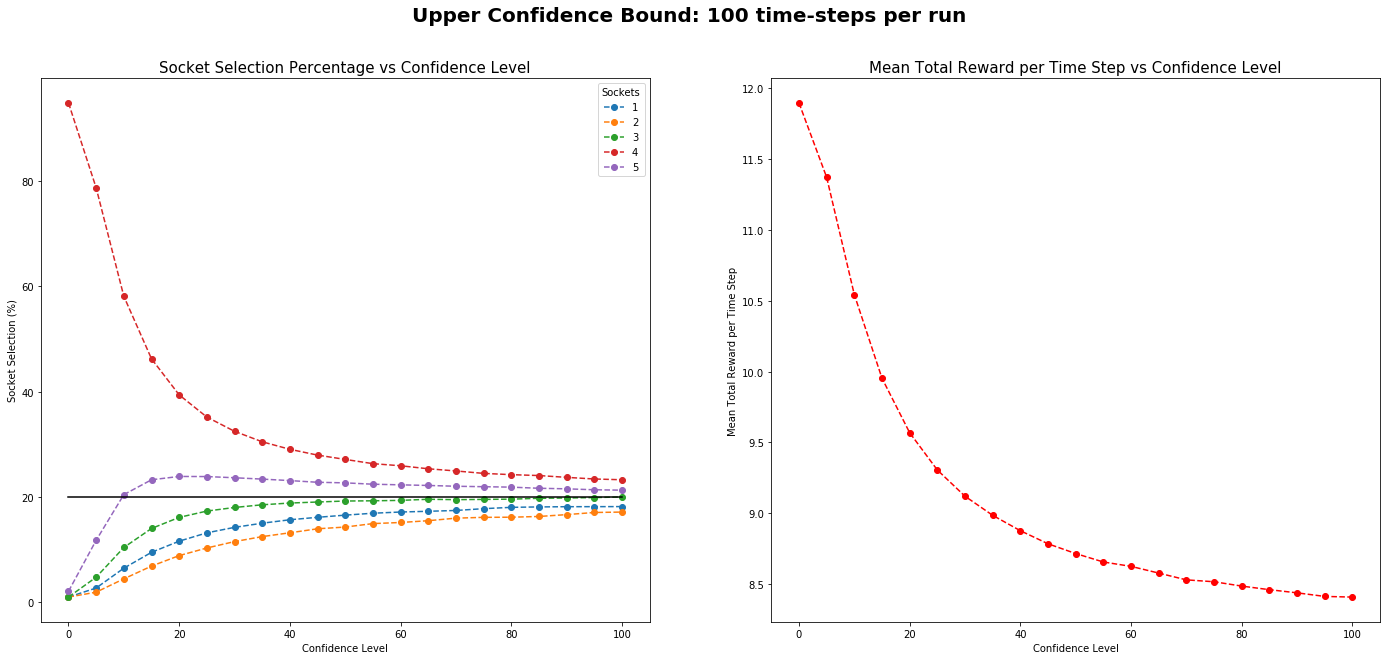

In [10]:
plot_ucb(confidence_values, 
         reward_per_timestep, 
         optimal_selected, 
         socket_percentages, 
         final_socket_estimates, 
         number_of_steps )

A closer examination of the variation of the mean total reward as the confidence level is increased is shown below. Here it can be seen that the mean total reward does increase slightly, from having a confidence parameter of zero up to a value of about 0.6, after which it falls off rapidly. So a small degree of exploration is required to get the best results.

In [11]:
# how many times each test should be run
number_of_tests = 1000

# the confidence level test range
start = 0.
stop = 2.0
step = 0.1

number_of_steps = 50
confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_ucb_experiment( start, stop, step, number_of_tests, number_of_steps )  

100%|██████████| 21/21 [01:59<00:00,  5.71s/it]


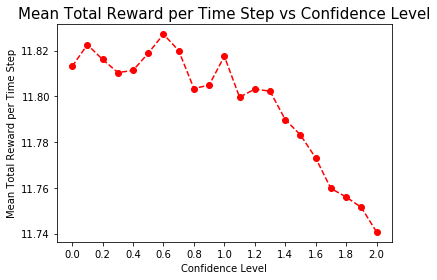

In [12]:
plt.xticks(np.arange(0., 2.2, 0.2))
plt.plot( confidence_values, reward_per_timestep, marker='o', linestyle='--', color='r') 
plt.title('Mean Total Reward per Time Step vs Confidence Level', fontsize=15)
plt.xlabel('Confidence Level')
plt.ylabel('Mean Total Reward per Time Step') 
plt.savefig(f"Images/ucb_reward_per_timestep{number_of_steps}.png")

Analysing how often each socket is selected, with the confidence parameter set to a value of 0.6 (the value that gave the maximum mean total reward, as shown above), gives the graph shown below. Here it can be seen that during the initial priming round, when a socket's uncertainty is set to infinity if it has not yet been tried, that each socket is selected once during the first 5 time steps. After this point the optimal socket (socket 4) has already been identified as the best socket and so is selected for nearly all of the remaining trials.

In [13]:
# create and test UCB sockets
tester = UCBSocketTester( confidence_level = 0.6)
tester.run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage()}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 11.991760991046698
Optimal Socket Selected = 0.995995995995996
Socket Percentages = [0.001 0.001 0.001 0.996 0.001]


In [14]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 1000
number_of_steps = 1000    

experiment = SocketExperiment(socket_tester   = UCBSocketTester( confidence_level = 0.6 ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()

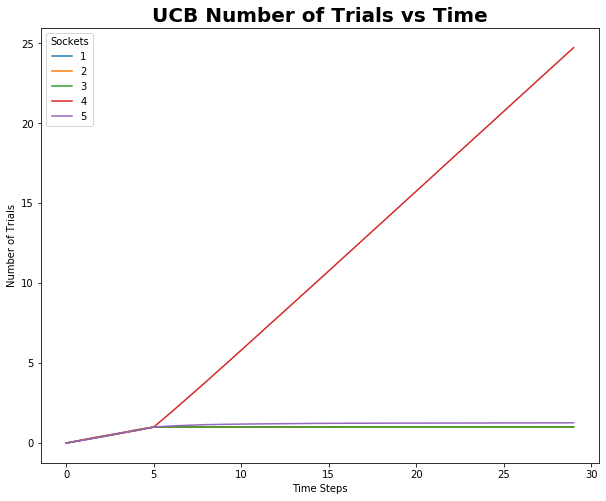

In [15]:
number_of_trials = experiment.get_number_of_trials()

plt.figure(figsize=(10,8))
for socket in range(number_of_trials.shape[1]):
    plt.plot(number_of_trials[:30,socket], label = f'{socket+1}')  
    
plt.title('UCB Number of Trials vs Time', fontsize=20, fontweight='bold')
plt.legend(title = 'Sockets')
plt.xlabel('Time Steps')
plt.ylabel('Number of Trials')

plt.savefig("Images/UCB_number_of_trials.png")  

---

# UCB Regret

Due to the optimal action being identified quickly, and only trying the other actions when they have high uncertainty, the UCB method shows a much lower level of regret than seen in the Epsilon-Greedy method. 

As can be seen in the graphs below, the optimal and actual rewards are almost identical (so much so that the actual line is obscured by the optimal line) and regret is almost flat. 

The vast majority of the regret occurs during the initial priming round, where each socket is being tried once to get its first estimate. Indeed, it has been shown that the expected cumulative regret of UCB is logarithmic in 'T', the total number of time-steps.

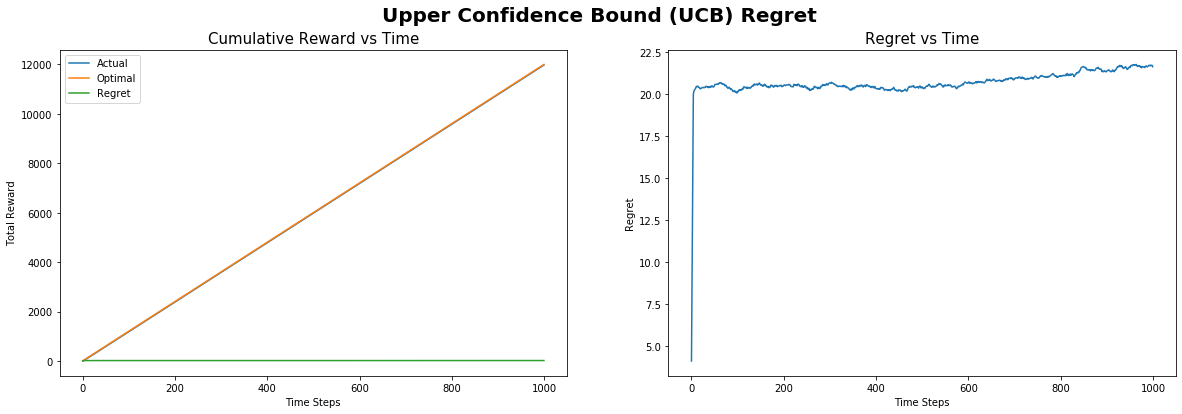

In [16]:
# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward 
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Upper Confidence Bound (UCB) Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.savefig(f"Images/ucb_regret.png")
plt.show()  

For an in-depth examination of UCB regret and UCB in general check out the following resources:

Tor Lattimore and Csaba Szepesvari's [book and website on Bandit Algorithms](https://banditalgs.com/2016/09/18/the-upper-confidence-bound-algorithm/)

Lai and Robbins' seminal paper on the UCB algorithm: "[Asymptotically efficient adaptive allocation rules](https://www.sciencedirect.com/science/article/pii/0196885885900028?via%3Dihub)".

# Summary

In problems such as Socket Selection or the Multi-Armed Bandit, when faced with the dilemma of how to strike a balance between searching for the actions that give the best return and exploiting those that have already been found, it is important to use an approach that can modify its levels of exploration and exploitation.

As we saw with the Epsilon-Greedy algorithm it simply maintains a constant level of exploration, continuing to explore the set of all actions as time progresses. As a result, it has linear regret. The difference between the reward it achieves and the maximum possible reward continues to increase with time.

On the other hand, the Upper Confidence Bound (UCB) algorithm modifies its levels of exploration and exploitation. Initially, when it has little knowledge of the available actions, and a low confidence in the best actions to take, the exploration part of its equation causes it to search through the set of all possible actions. 

As exploration progresses better estimates are formed for the outputs of each action. The level of exploration can be decreased and the use of the good actions that have been found can increase. Gradually the focus of the algorithm swings from exploration to favour exploitation. By shifting this balance as time progresses the UCB algorithm reduces its regret and, consequently, is able to achieve a much lower level of regret than that seen in Epsilon-Greedy.

---

In the next part we'll take a look at Thompson Sampling, an even more sophisticated approach to balancing exploration and exploitation. Using this we'll get Baby Robot charged and ready to go in practically no time!

![](Images/green_babyrobot_small.gif)